# BEE 4750 Lab 3: Linear Programming with JuMP

**Name**:

**ID**:

> **Due Date**
>
> Friday, 10/13/23, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

In [2]:
using JuMP # optimization modeling syntax
using HiGHS # optimization solver
using Plots # plotting

## Overview

In this lab, you will write and solve a resource allocation example
using `JuMP.jl`. `JuMP.jl` provides an intuitive syntax for writing,
solving, and querying optimization problems.

For an example of using `JuMP.jl` to solve linear programs, see [the
relevant tutorial on the class
website](https://viveks.me/environmental-systems-analysis/tutorials/julia-jump.html).

Free free to delete some of the illustrative cells and code blocks in
your notebook as you go through and solve the lab problems…this might
help reduce some potential confusion while grading about what your
answer is.

## Introduction

Your task is to decide how much lumber to produce to maximize profit
from wood sales. You can purchase wood from a managed forest, which
consists of spruce (320,000 bf) and fir (720,000 bf). Spruce costs
\$0.12 per bf to purchase and fir costs \$0.08 per bf.

At the lumber mill, wood can be turned into plywood of various grades
(see <a href="#tbl-inputs" class="quarto-xref">Table 1</a> for how much
wood of each type is required for and the revenue from each grade). Any
excess wood is sent to be recycled into particle board. This resource
allocation problem is diagrammed in
<a href="#fig-schematic" class="quarto-xref">Figure 1</a>.

| Plywood Grade | Inputs (bf/bf plywood) | Revenue (\$/1000 bf) |
|:-------------:|:----------------------:|:--------------------:|
|       1       |   0.5 (S) + 1.5 (F)    |         400          |
|       2       |   1.0 (S) + 2.0 (F)    |         520          |
|       3       |   1.5 (S) + 2.0 (F)    |         700          |

Table 1: Wood inputs and revenue by plywood grade. S refers to spruce
inputs, F fir inputs.

<figure id="fig-schematic">
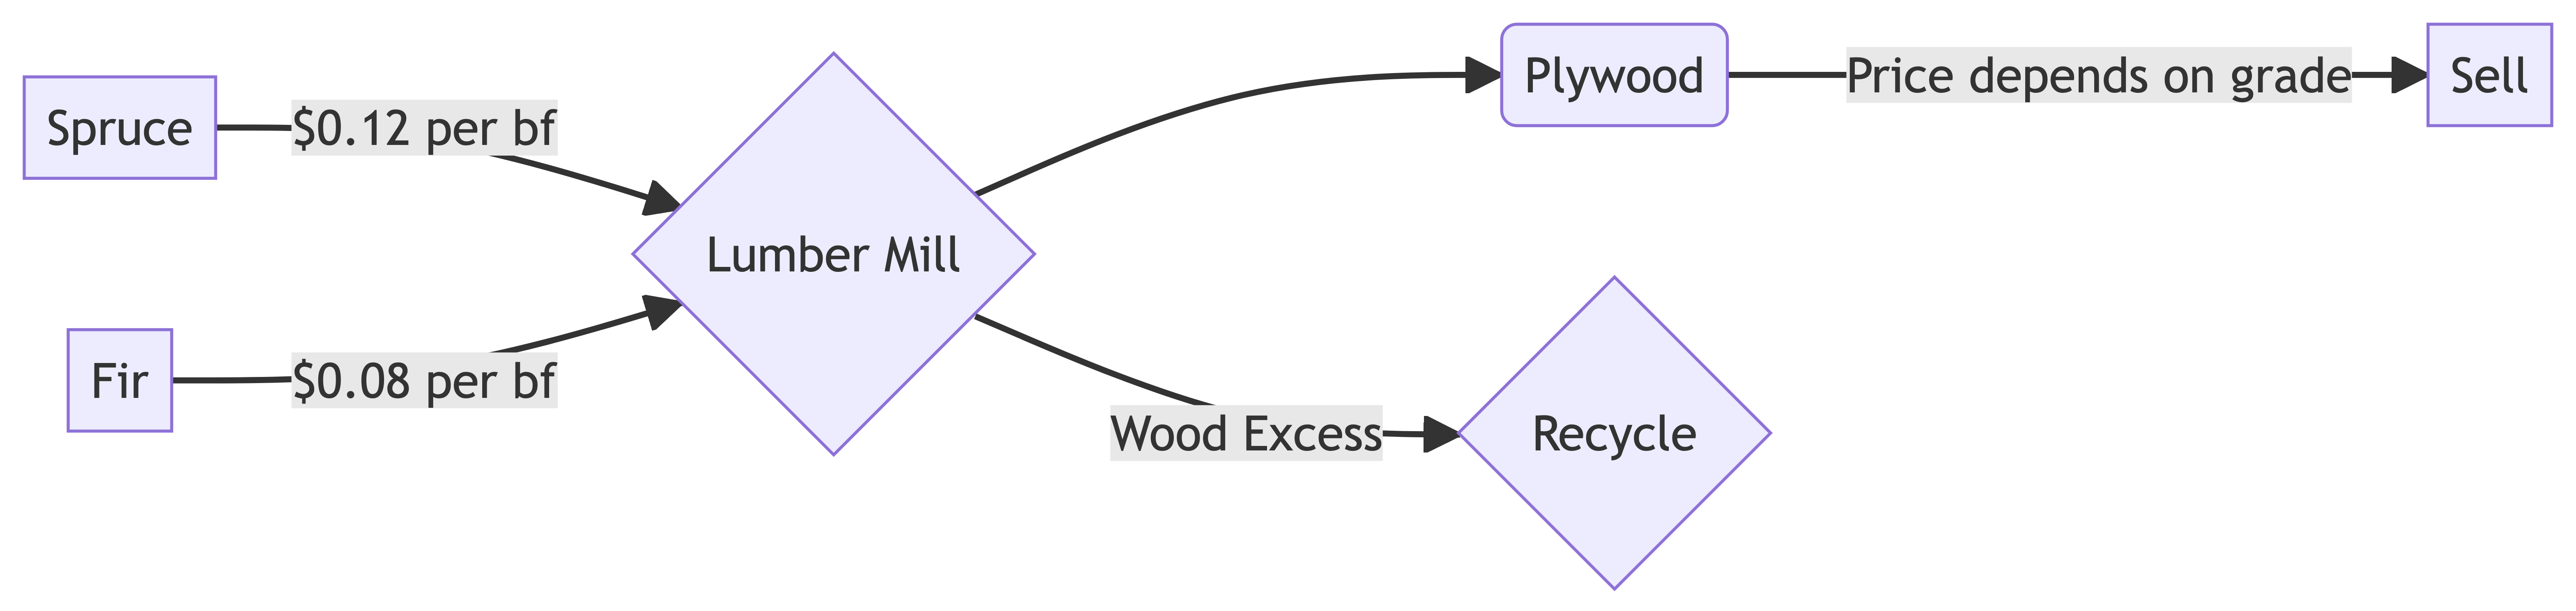
<figcaption>Figure 1: Flowchat of the resource allocation problem in
this lab.</figcaption>
</figure>

## Problems (10 points)

### Problem 1: Problem Formulation (5 points)

In this problem, you will go through the steps of formulating a linear
program for this problem.

#### Problem 1.1 (1 point)

What are your decision variables? Clearly define your notation,
including what variables you are using, what they mean, and what their
units are.

#### Problem 1.2 (1 point)

Derive your objective function. Support your function with
justifications and/or equations as necessary. You will not receive
credit just for the function alone.

#### Problem 1.3 (2 point)

Derive any needed constraints. Support your function with justifications
and/or equations as necessary. You will not receive credit just for the
final constraints alone.

#### Problem 1.4 (1 point)

Put this optimization problem in mathematical programming form. For an
example of the syntax for this, see lines 82–91
[here](https://github.com/vsrikrish/environmental-systems-analysis/blob/Fall23/tutorials/julia-jump.qmd).

### Problem 2: Find the Solution (5 points)

#### Problem 2.1 (2 points)

Code your linear program using `JuMP`. Feel free to consult [the
website’s `JuMP`
tutorial](https://viveks.me/environmental-systems-analysis/tutorials/julia-jump.html)
for syntax help. The keys:

1.  Initialize your model with a solver; in this case, we’ll use the
    `HiGHS` solver, but there are other solvers listed here for
    different types of problems, some of which are open and some of
    which require a commercial license:
    <https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers>:

    ``` julia
    example_model = Model(HiGHS.Optimizer)
    ```

2.  Define variables with syntax like

    ``` julia
    @variable(example_model, 1 >= example_x >= 0)
    ```

    This will create a variable `example_x` which is constrained to be
    between 0 and 1; you can leave off any of the bounds if a variable
    is unbounded in a particular direction. You can also add a vector of
    variables:

    ``` julia
    T = 1:3 # define set to index variables
    @variable(example_model, 1 >= example_z[t in T] >= 0)
    ```

    which will create a vector of 3 variables `example_z[1]`, …,
    `example_z[3]`, all of which are bounded between 0 and 1.

3.  Add an objective with

    ``` julia
    @objective(example_model, Max, example_x + sum(example_z))
    ```

    which will add an objective to maximize (replace with `Min` to
    minimize).

4.  Add constraints:

    ``` julia
    @constraint(example_model, constraint1, 2example_x + 3*sum(example_z) <= 10)
    @constraint(example_model, constraint2, 5example_x - example_z[1] <= 2)
    ```

    which will name the constraints `constraint1` and `constraint2` (you
    should make yours more descriptive about what the constraint
    actually is). The value of adding a name is to facilitate later
    querying of shadow prices, which we will discuss later. You can also
    add a vector of constraints which have similar structure or rely on
    different elements of a data vector:

    ``` julia
    A = [2; 4]
    b = [8; 12]
    I = 1:2 # set indices for constraint
    @constraint(example_model, vector_constraint[i in I], A[i] * sum(example_z) .<= b[i])
    ```

    You can also define matrices of constraints which depend on two
    index sets by generalizing this syntax, e.g.

    ``` julia
    @constraint(example_model, matrix_constraint[i in I, j in J, ...])
    ```

    > **Tip**
    >
    > Specifying higher-dimensional vectors and matrices of variables
    > and constraints will be important when we start looking at more
    > complex applications, so don’t skip over this! You don’t want to
    > manually enter thousands of constraints to ensure hourly
    > electricity demand is met…

    Finally, you can (and probably should) `print` your model to make
    sure that you get something that looks like the equations that you
    wrote down (in a notebook, this will be nicely rendered):

    ``` julia
    print(example_model)
    ```

    $$ \begin{aligned}
    \max\quad & example\_x + example\_z_{1} + example\_z_{2} + example\_z_{3}\\
    \text{Subject to} \quad & 2 example\_x + 3 example\_z_{1} + 3 example\_z_{2} + 3 example\_z_{3} \leq 10\\
     & 5 example\_x - example\_z_{1} \leq 2\\
     & 2 example\_z_{1} + 2 example\_z_{2} + 2 example\_z_{3} \leq 8\\
     & 4 example\_z_{1} + 4 example\_z_{2} + 4 example\_z_{3} \leq 12\\
     & example\_x \geq 0\\
     & example\_z_{1} \geq 0\\
     & example\_z_{2} \geq 0\\
     & example\_z_{3} \geq 0\\
     & example\_x \leq 1\\
     & example\_z_{1} \leq 1\\
     & example\_z_{2} \leq 1\\
     & example\_z_{3} \leq 1\\
    \end{aligned} $$

    > **Define your entire model in one cell**
    >
    > `JuMP` has great and intuitive syntax, but it doesn’t like
    > re-defining variables or constraints once they’ve been set. I
    > recommend putting all of your model-definition code (starting from
    > `model = Model(...)`) for a particular optimization problem in a
    > single notebook cell, so you can re-set up the entire problem with
    > a single click when you want to make a change.

#### Problem 2.2 (1 points)

Find the solution to your program and find the optimal values of the
decision variables. Once you’ve defined your model, you can find the
solution with \`optimize!():

In [10]:
optimize!(example_model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 4 cols, 6 nonzeros
2 rows, 3 cols, 5 nonzeros
2 rows, 3 cols, 5 nonzeros
Presolve : Reductions: rows 2(-2); columns 3(-1); elements 5(-7)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          2    -3.5333333333e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  3.5333333333e+00
HiGHS run time      :          0.00

> **What if I Get An Error?**
>
> If `optimize!()` throws an error, that’s usually a sign that something
> is wrong with the formulation (for example, a variable might not be
> bounded or a constraint might not be specified correctly) or a typo in
> the model definition. Linear programs should be well behaved!

To find the values of variables after optimizing, use `value.()` (the
broadcasting ensures this will work for vector-valued variables as
well):

In [11]:
value.(example_x)

0.6

In [12]:
value.(example_z)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:3
And data, a 3-element Vector{Float64}:
 1.0
 0.9333333333333332
 1.0

#### Problem 2.3 (1 point)

How would your profit change if you could buy 1,000 additional bf of
spruce? You can answer this by getting the shadow price of a particular
variable with:

In [13]:
shadow_price(constraint1) # this is why we named the constraints when we defined them

0.3333333333333333

#### Problem 2.4 (1 point)

Would you prefer to have 2,000 additional bf of spruce or 1,000
additional bf of fir?

## References

Put any consulted sources here, including classmates you worked with/who
helped you.